# Initialization

## Import Packages 

In [2]:
from sklearn.tree import DecisionTreeRegressor
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from scipy.io import arff
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import time
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve
import os
from sklearn.ensemble import GradientBoostingRegressor
import arff
from tqdm import tqdm
import pixiedust

from copy import deepcopy

Pixiedust database opened successfully


## GBDT main class

In [3]:
class GBDT(object):
    def __init__(self,
                 max_iter = 50,
                 sample_rate = 0.8,
                 learn_rate = 0.01,
                 max_depth = 10,
                 new_tree_max_iter = 10,
                 min_samples_leaf = 5):

        self.max_iter = max_iter
        self.sample_rate = sample_rate # 0 < sample_rate <= 1
        self.learn_rate = learn_rate
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
        self.dtrees = []
        self.original_f = None
        self.new_tree_max_iter = new_tree_max_iter

    def fit(self, x_train, y_train):

        n, m = x_train.shape
        
        f = np.ones(n) * np.mean(y_train)
        self.original_f = np.mean(y_train)
        self.residual_mean = np.zeros(self.max_iter)
        n_sample = int(n * self.sample_rate)

        for iter_ in range(self.max_iter): 
            sample_idx = np.random.permutation(n)[:n_sample]
            x_train_subset, y_train_subset = x_train[sample_idx, :], y_train[
                sample_idx]
            y_predict_subset = np.zeros(n_sample)
            
            for j in range(n_sample):
                k = sample_idx[j]
                y_predict_subset[j] = f[k]

            residual = y_train_subset - y_predict_subset

            dtree = DecisionTreeRegressor(max_depth = self.max_depth, min_samples_leaf=self.min_samples_leaf)
            # fit to negative gradient
            dtree.fit(x_train_subset, residual * self.learn_rate)
            self.dtrees.append(dtree)  # append new tree

            # update prediction score
            for j in range(n):
                pre = dtree.predict(np.array([x_train[j]]))
                f[j] += pre

    def predict(self, x):

        n = x.shape[0]
        y = np.zeros([n, len(self.dtrees)])
        
        for iter_ in range(len(self.dtrees)):
            dtree = self.dtrees[iter_]

            y[:, iter_] = dtree.predict(x)

        init_residual = np.ones(y.shape[0]) * self.original_f
        self.cumulated_pred_score = np.cumsum(y, axis = 1)
        return np.sum(y, axis = 1) + init_residual.reshape(1, -1)
    
    def best_tree_purning(self, y_test):
        init_residual = np.ones(y_test.shape[0]) * self.original_f
        residual = y_test.reshape(1, -1) - init_residual.reshape(1, -1)
        residual_mat = np.repeat(residual, len(self.dtrees), axis = 0).T
        tree_purning_residual = np.abs(residual_mat - self.cumulated_pred_score)
        tree_purning_residual = np.mean(tree_purning_residual, axis = 0)
        tree_purning_idx = np.argmin(tree_purning_residual)
        self.dtrees = self.dtrees[:tree_purning_idx + 1]
        self.max_iter = len(self.dtrees)
        return tree_purning_residual
        
        
    def incremental_fit(self, x_test, y_test, pred_score, new_tree_max_iter):
        
        n, m = x_test.shape
        
        f = pred_score
      
        n_sample = int(n*self.sample_rate)
        
        for iter_ in range(new_tree_max_iter):
            
            sample_idx = np.random.permutation(n)[:n_sample]
            
            y_residual = y_test - f
            x_train_subset, residual_train_subset = x_test[sample_idx, :], y_residual[sample_idx]
            
            new_tree = DecisionTreeRegressor(max_depth = self.max_depth)
            new_tree.fit(x_train_subset, residual_train_subset * self.learn_rate)
            self.dtrees.append(new_tree)
            self.max_iter += 1
            
            for j in range(n):
                pre = new_tree.predict(np.array([x_test[j]]))
                f[j] += pre

## Loading .arff Dataset

In [4]:
def load_arff(path, dataset_name, num_copy):
    if num_copy == -1:
        file_path = path + dataset_name + '/'+ dataset_name + '.arff'
        dataset = arff.load(open(file_path), encode_nominal=True)
    else:
        file_path = path + dataset_name + '/'+ dataset_name + str(num_copy) + '.arff'
        dataset = arff.load(open(file_path), encode_nominal=True)
    return np.array(dataset["data"])

# Experiment

## Algorithms

### GBDT Baseline

In [25]:
def evaluation_baseline_GBDT(data, ini_train_size, win_size, **GBDT_parm):

    x_train = data[0:ini_train_size, :-1]
    y_train = data[0:ini_train_size, -1]

    model = GBDT(**GBDT_parm)
    model.fit(x_train, y_train)

    kf = KFold(int((data.shape[0] - ini_train_size) / win_size))
    stream = data[ini_train_size:, :]
    pred = np.zeros(stream.shape[0])
    batch_acc = []
    batch_f1 = []
    
    for train_index, test_index in tqdm(kf.split(stream), total=kf.get_n_splits(), desc="#batch"):
        
        x_test = stream[test_index, :-1]
        y_test = stream[test_index, -1]

        y_residual = model.predict(x_test)
        y_pred = (y_residual >= 0.5)
        
        pred[test_index] = y_pred
        batch_acc.append(metrics.accuracy_score(y_test, y_pred.T))
        batch_f1.append(metrics.f1_score(y_test, y_pred.T,average='macro'))
    
    return batch_acc, batch_f1, pred

### Naive Incremental GBDT (iGBDT)

In [26]:
def evaluation_naive_iGBDT(data, ini_train_size, win_size, num_inc_tree, **GBDT_parm):

    x_train = data[0:ini_train_size, :-1]
    y_train = data[0:ini_train_size, -1]        

    model = GBDT(**GBDT_parm)
    model.fit(x_train, y_train)

    kf = KFold(int((data.shape[0] - ini_train_size) / win_size))
    stream = data[ini_train_size:, :]
    pred = np.zeros(stream.shape[0])
    batch_acc = []
    batch_f1=[]

    
    for train_index, test_index in tqdm(kf.split(stream), total=kf.get_n_splits(), desc="#batch"):

        x_test = stream[test_index, :-1]
        y_test = stream[test_index, -1]

        y_pred_score = model.predict(x_test)
        y_pred_label = (y_pred_score >= 0.5)
        
        batch_acc.append(metrics.accuracy_score(y_test, y_pred_label.T))
        batch_f1.append(metrics.f1_score(y_test, y_pred_label.T ,average='macro'))
        
        pred[test_index] = y_pred_label

        y_pred_score = model.predict(x_test)
        y_pred_score = np.squeeze(y_pred_score)
        
        model.incremental_fit(x_test, y_test, y_pred_score, num_inc_tree)
                
        x_train = x_test
        y_train = y_test
    
    return batch_acc, batch_f1, pred

### eGBDT

In [12]:
def evaluation_eGBDT(data, ini_train_size, win_size, max_tree, num_ince_tree, **GBDT_pram):

    x_train = data[0:ini_train_size, :-1]
    y_train = data[0:ini_train_size, -1]
    model = GBDT(**GBDT_pram)
    model.fit(x_train, y_train)

    kf = KFold(int((data.shape[0] - ini_train_size) / win_size))
    stream = data[ini_train_size:, :]
    pred = np.zeros(stream.shape[0])
    accuracy = []
    f1 = []
    prune_tree = []#kun
    tree_before_purning = []
    tree_after_purning = []
    best_tree_index = []
    tree_purning_residual = []

    for train_index, test_index in tqdm(kf.split(stream), total=kf.get_n_splits(), desc="#batch"):

        x_test = stream[test_index, :-1]
        y_test = stream[test_index, -1]
        
        # Step 1. Make Prediction
        y_pred_score = model.predict(x_test)
        y_pred_score = np.squeeze(y_pred_score)
        y_pred_label = (y_pred_score >= 0.5)

        accuracy.append(metrics.accuracy_score(y_test, y_pred_label.T))
        f1.append(metrics.f1_score(y_test,y_pred_label.T,average='macro'))
        
        pred[test_index] = y_pred_label
        
        # Step 2. Purning GBDT
        num_tree_before_purning = len(model.dtrees)
        tree_residual = model.best_tree_purning(y_test)
        num_tree_after_purning = len(model.dtrees)
        
        best_tree_index.append(num_tree_after_purning)
        tree_purning_residual.append(tree_residual)
        
        
        #print(test_index[0], 'Purned Num Tree,', num_tree_before_purning - num_tree_after_purning)
        prune_tree.append(num_tree_before_purning - num_tree_after_purning)#kun
        tree_before_purning.append(num_tree_before_purning)
        tree_after_purning.append(num_tree_after_purning)
        
        # Step 3. Update GBDT
        # Step 3.1 Drift Detection, If num_tree < num_base
        if num_tree_after_purning < GBDT_pram['max_iter']:
            model = GBDT(**GBDT_pram)
            model.fit(x_test, y_test)
            GBDT_ensemble_dict = {}
            last_best = 1
        else:
            # Step 3.2 Incremental Update with Fixed Number of Trees
            # This parameter can be ensemble, such as {5, 10, 15 20, 25}
            if len(model.dtrees) <= max_tree:
                y_pred_score = np.squeeze(model.predict(x_test))
                model.incremental_fit(x_test, y_test, y_pred_score, num_ince_tree)
    tqdm.write('Num tree at the end,' + str(len(model.dtrees)))
    
    
    
    best_tree_index = pd.DataFrame(best_tree_index)
    plt.figure(figsize=(6, 2.5))
    plt.plot(best_tree_index)
    plt.xlabel('chunk')
    plt.ylabel('best tree index')
    plt.show()
    
    
    
    tree_purning_residual = pd.DataFrame(tree_purning_residual)
    
   
    #print('index',best_tree_index)
    #print('tree_purning_residual',tree_purning_residual)
    
    return accuracy, f1, pred, best_tree_index, prune_tree#,tree_before_purning,tree_after_purning#kun

## Run Real-world Experiment

In [13]:
def exp_realworld(path, dataset_name, num_run, exp_function, **exp_parm):

    aver_total_acc = np.zeros(num_run)
    aver_total_f1 = np.zeros(num_run)

    np.random.seed(0)
    data = load_arff(path, dataset_name, -1)
    num_eval = int(
        (data.shape[0] - exp_parm['ini_train_size']) / exp_parm['win_size'])
    batch_acc = np.zeros([num_run, num_eval])
    batch_f1 = np.zeros([num_run, num_eval])

    
    
    tqdm.write('='*20)
    tqdm.write((dataset_name + str(0)).center(20))
    batch_acc[0], batch_f1[0], pred,best_tree_index, prune_tree= exp_function(data, **exp_parm)
    aver_total_acc[0] = metrics.accuracy_score(
        data[exp_parm['ini_train_size']:, -1], pred)
    aver_total_f1[0] = metrics.f1_score(
        data[exp_parm['ini_train_size']:, -1], pred,average='macro')

    tqdm.write('Current r_seed acc,' + str(aver_total_acc[0]))
    tqdm.write('Current r_seed f1,' + str(aver_total_f1[0]))
    
    #np.savetxt(str(dataset_name)+'_iGBDT_batch_acc'+'.out', batch_acc[0] , delimiter=',')
    #np.savetxt(str(dataset_name)+'_iGBDT_batch_f1'+'.out', batch_f1[0] , delimiter=',')
    #np.savetxt(str(dataset_name)+'_tree_number'+'.out', best_tree_index , delimiter=',')
    np.savetxt(str(dataset_name)+'_prune_tree_number'+'.out', prune_tree , delimiter=',')
    
#save result
    print(pred.shape)
    print(data[exp_parm['ini_train_size']:, -1].shape)
    result = np.zeros([pred.shape[0], 2])
    result[:, 0] = pred
    result[:, 1] = data[exp_parm['ini_train_size']:, -1]
    np.savetxt(str(dataset_name)+'.out', result , delimiter=',')
    
    
    for r_seed in range(1, num_run):
        np.random.seed(r_seed)
        data = load_arff(path, dataset_name, -1)
        num_eval = int((data.shape[0] - exp_parm['ini_train_size']) /
                       exp_parm['win_size'])
        tqdm.write('='*20)
        tqdm.write((dataset_name + str(r_seed)).center(20))
        batch_acc[r_seed], batch_f1[r_seed],pred, best_tree_index = exp_function(data, **exp_parm)
        aver_total_acc[r_seed] = metrics.accuracy_score(
            data[exp_parm['ini_train_size']:, -1], pred)
        tqdm.write('Current r_seed acc,' + str(aver_total_acc[r_seed]))
        aver_total_f1[r_seed] = metrics.f1_score(
            data[exp_parm['ini_train_size']:, -1], pred, average='macro')

        
        tqdm.write('Current r_seed acc,' + str(aver_total_acc[r_seed]))
        tqdm.write('Current r_seed f1,' + str(aver_total_f1[r_seed]))

        

        
    tqdm.write('Average acc,' + str(np.mean(aver_total_acc)))
    tqdm.write('Average f1,' + str(np.mean(aver_total_f1)))
    tqdm.write('Std acc,' + str(np.std(aver_total_acc)))
     
    

In [14]:
path = 'Noaa/'
num_run = 1
datasets = [
    'noaa_042700','noaa_100370','noaa_265090','noaa_424750','noaa_567780',
    'noaa_606560','noaa_702220','noaa_802220'
]

## eGBDT

### noaa_042700

    noaa_0427000    


#batch: 100%|██████████| 74/74 [01:03<00:00,  1.16it/s]

Num tree at the end,1035


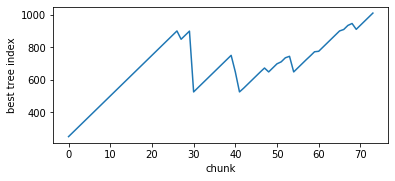

Current r_seed acc,0.7916115763184957
Current r_seed f1,0.791544065256437
(27228,)
(27228,)
Average acc,0.7916115763184957
Average f1,0.791544065256437
Std acc,0.0


In [15]:
eGBDT_parm = {
    'ini_train_size': 365,
    'win_size': 365,
    'max_tree': 10000,
    'num_ince_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

eGBDT_parm.update(GBDT_pram)
dataset_name = 'noaa_042700'
exp_realworld(path, dataset_name, num_run, evaluation_eGBDT,
              **eGBDT_parm)

### noaa_100370

    noaa_1003700    


#batch: 100%|██████████| 73/73 [01:02<00:00,  1.17it/s]

Num tree at the end,786


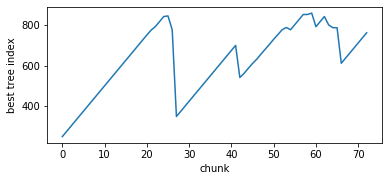

Current r_seed acc,0.851151713615897
Current r_seed f1,0.8138386757400724
(26873,)
(26873,)
Average acc,0.851151713615897
Average f1,0.8138386757400724
Std acc,0.0


In [16]:
eGBDT_parm = {
    'ini_train_size': 365,
    'win_size': 365,
    'max_tree': 10000,
    'num_ince_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

eGBDT_parm.update(GBDT_pram)
dataset_name = 'noaa_100370'
exp_realworld(path, dataset_name, num_run, evaluation_eGBDT,
              **eGBDT_parm)

### noaa_265090

    noaa_2650900    


#batch: 100%|██████████| 69/69 [00:57<00:00,  1.19it/s]

Num tree at the end,854


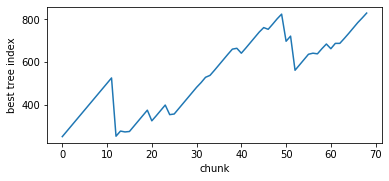

Current r_seed acc,0.7740822960437643
Current r_seed f1,0.7701560805696077
(25226,)
(25226,)
Average acc,0.7740822960437643
Average f1,0.7701560805696077
Std acc,0.0


In [17]:
eGBDT_parm = {
    'ini_train_size': 365,
    'win_size': 365,
    'max_tree': 10000,
    'num_ince_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

eGBDT_parm.update(GBDT_pram)
dataset_name = 'noaa_265090'
exp_realworld(path, dataset_name, num_run, evaluation_eGBDT,
              **eGBDT_parm)

### noaa_424750

    noaa_4247500    


#batch: 100%|██████████| 48/48 [00:38<00:00,  1.25it/s]

Num tree at the end,582


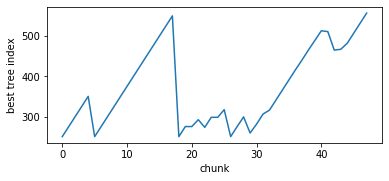

Current r_seed acc,0.8800925403453335
Current r_seed f1,0.8296889410064976
(17722,)
(17722,)
Average acc,0.8800925403453335
Average f1,0.8296889410064976
Std acc,0.0


In [18]:
eGBDT_parm = {
    'ini_train_size': 365,
    'win_size': 365,
    'max_tree': 10000,
    'num_ince_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

eGBDT_parm.update(GBDT_pram)
dataset_name = 'noaa_424750'
exp_realworld(path, dataset_name, num_run, evaluation_eGBDT,
              **eGBDT_parm)

### noaa_567780

    noaa_5677800    


#batch: 100%|██████████| 69/69 [01:00<00:00,  1.15it/s]

Num tree at the end,1240


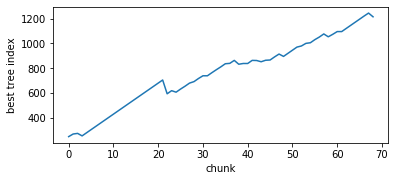

Current r_seed acc,0.8043220137734505
Current r_seed f1,0.8014475997357847
(25266,)
(25266,)
Average acc,0.8043220137734505
Average f1,0.8014475997357847
Std acc,0.0


In [19]:
eGBDT_parm = {
    'ini_train_size': 365,
    'win_size': 365,
    'max_tree': 10000,
    'num_ince_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

eGBDT_parm.update(GBDT_pram)
dataset_name = 'noaa_567780'
exp_realworld(path, dataset_name, num_run, evaluation_eGBDT,
              **eGBDT_parm)

### noaa_606560

    noaa_6065600    


#batch:  48%|████▊     | 21/44 [00:16<00:19,  1.18it/s]/home/kunwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
#batch:  55%|█████▍    | 24/44 [00:19<00:17,  1.16it/s]/home/kunwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
#batch:  57%|█████▋    | 25/44 [00:20<00:16,  1.15it/s]/home/kunwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
#batch: 100%|██████████| 44/44 [00:37<00:00,  1.17it/s]

Num tree at the end,934


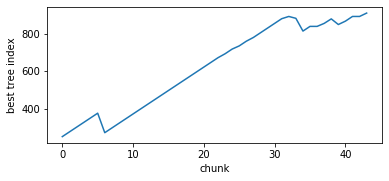

Current r_seed acc,0.9586376189015036
Current r_seed f1,0.679559619463937
(16295,)
(16295,)
Average acc,0.9586376189015036
Average f1,0.679559619463937
Std acc,0.0


In [20]:
eGBDT_parm = {
    'ini_train_size': 365,
    'win_size': 365,
    'max_tree': 10000,
    'num_ince_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

eGBDT_parm.update(GBDT_pram)
dataset_name = 'noaa_606560'
exp_realworld(path, dataset_name, num_run, evaluation_eGBDT,
              **eGBDT_parm)

### noaa_702220

    noaa_7022200    


#batch: 100%|██████████| 73/73 [01:08<00:00,  1.07it/s]

Num tree at the end,781


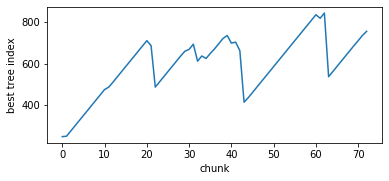

Current r_seed acc,0.7530187835420393
Current r_seed f1,0.7465736754179206
(26832,)
(26832,)
Average acc,0.7530187835420393
Average f1,0.7465736754179206
Std acc,0.0


In [21]:
eGBDT_parm = {
    'ini_train_size': 365,
    'win_size': 365,
    'max_tree': 10000,
    'num_ince_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

eGBDT_parm.update(GBDT_pram)
dataset_name = 'noaa_702220'
exp_realworld(path, dataset_name, num_run, evaluation_eGBDT,
              **eGBDT_parm)

### noaa_802220

    noaa_8022200    


#batch:  20%|█▉        | 13/66 [00:10<00:41,  1.28it/s]/home/kunwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
#batch: 100%|██████████| 66/66 [01:06<00:00,  1.01s/it]

Num tree at the end,570


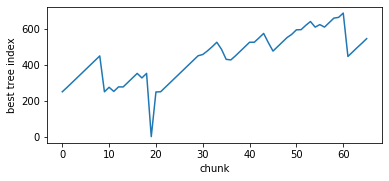

Current r_seed acc,0.7519699657576633
Current r_seed f1,0.7091007013257571
(24239,)
(24239,)
Average acc,0.7519699657576633
Average f1,0.7091007013257571
Std acc,0.0


In [22]:
eGBDT_parm = {
    'ini_train_size': 365,
    'win_size': 365,
    'max_tree': 10000,
    'num_ince_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

eGBDT_parm.update(GBDT_pram)
dataset_name = 'noaa_802220'
exp_realworld(path, dataset_name, num_run, evaluation_eGBDT,
              **eGBDT_parm)

## GBDT Baseline

### noaa_042700

In [57]:
GBDT_base = {
    'ini_train_size': 365,
    'win_size': 365,
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

GBDT_base.update(GBDT_pram)
dataset_name = 'noaa_042700'
exp_realworld(path, dataset_name, num_run, evaluation_baseline_GBDT,
              **GBDT_base)

    noaa_0427000    


#batch:   7%|▋         | 5/74 [00:00<00:01, 43.74it/s]/home/kunwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kunwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kunwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kunwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'p

Current r_seed acc,0.46106948729249303
Current r_seed f1,0.32696449113191806
(27228,)
(27228,)
Average acc,0.46106948729249303
Average f1,0.32696449113191806
Std acc,0.0


### noaa_100370

In [58]:
GBDT_base = {
    'ini_train_size': 365,
    'win_size': 365,
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

GBDT_base.update(GBDT_pram)
dataset_name = 'noaa_100370'
exp_realworld(path, dataset_name, num_run, evaluation_baseline_GBDT,
              **GBDT_base)

    noaa_1003700    


#batch: 100%|██████████| 73/73 [00:01<00:00, 41.20it/s]


Current r_seed acc,0.7274959997023034
Current r_seed f1,0.6367784452322862
(26873,)
(26873,)
Average acc,0.7274959997023034
Average f1,0.6367784452322862
Std acc,0.0


### noaa_265090

In [59]:
GBDT_base = {
    'ini_train_size': 365,
    'win_size': 365,
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

GBDT_base.update(GBDT_pram)
dataset_name = 'noaa_265090'
exp_realworld(path, dataset_name, num_run, evaluation_baseline_GBDT,
              **GBDT_base)

    noaa_2650900    


#batch: 100%|██████████| 69/69 [00:01<00:00, 41.98it/s]


Current r_seed acc,0.7003884880678665
Current r_seed f1,0.6993367169059088
(25226,)
(25226,)
Average acc,0.7003884880678665
Average f1,0.6993367169059088
Std acc,0.0


### noaa_424750

In [60]:
GBDT_base = {
    'ini_train_size': 365,
    'win_size': 365,
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

GBDT_base.update(GBDT_pram)
dataset_name = 'noaa_424750'
exp_realworld(path, dataset_name, num_run, evaluation_baseline_GBDT,
              **GBDT_base)

    noaa_4247500    


#batch: 100%|██████████| 48/48 [00:01<00:00, 44.05it/s]


Current r_seed acc,0.8215777000338562
Current r_seed f1,0.7392507995997534
(17722,)
(17722,)
Average acc,0.8215777000338562
Average f1,0.7392507995997534
Std acc,0.0


### noaa_567780

In [61]:
GBDT_base = {
    'ini_train_size': 365,
    'win_size': 365,
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

GBDT_base.update(GBDT_pram)
dataset_name = 'noaa_567780'
exp_realworld(path, dataset_name, num_run, evaluation_baseline_GBDT,
              **GBDT_base)

    noaa_5677800    


#batch: 100%|██████████| 69/69 [00:01<00:00, 42.94it/s]


Current r_seed acc,0.6521412174463707
Current r_seed f1,0.6496015902826245
(25266,)
(25266,)
Average acc,0.6521412174463707
Average f1,0.6496015902826245
Std acc,0.0


### noaa_606560

In [62]:
GBDT_base = {
    'ini_train_size': 365,
    'win_size': 365,
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

GBDT_base.update(GBDT_pram)
dataset_name = 'noaa_606560'
exp_realworld(path, dataset_name, num_run, evaluation_baseline_GBDT,
              **GBDT_base)

    noaa_6065600    


#batch: 100%|██████████| 44/44 [00:01<00:00, 41.71it/s]

Current r_seed acc,0.7296103099110156
Current r_seed f1,0.5031607343977189
(16295,)
(16295,)
Average acc,0.7296103099110156
Average f1,0.5031607343977189
Std acc,0.0


### noaa_702220

In [63]:
GBDT_base = {
    'ini_train_size': 365,
    'win_size': 365,
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

GBDT_base.update(GBDT_pram)
dataset_name = 'noaa_702220'
exp_realworld(path, dataset_name, num_run, evaluation_baseline_GBDT,
              **GBDT_base)

    noaa_7022200    


#batch: 100%|██████████| 73/73 [00:01<00:00, 43.14it/s]


Current r_seed acc,0.5889236732259988
Current r_seed f1,0.48368243535128624
(26832,)
(26832,)
Average acc,0.5889236732259988
Average f1,0.48368243535128624
Std acc,0.0


### noaa_802220

In [64]:
GBDT_base = {
    'ini_train_size': 365,
    'win_size': 365,
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

GBDT_base.update(GBDT_pram)
dataset_name = 'noaa_802220'
exp_realworld(path, dataset_name, num_run, evaluation_baseline_GBDT,
              **GBDT_base)

    noaa_8022200    


#batch:  15%|█▌        | 10/66 [00:00<00:01, 42.69it/s]/home/kunwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/kunwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
#batch:  38%|███▊      | 25/66 [00:00<00:00, 44.05it/s]/home/kunwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
#batch:  45%|████▌     | 30/66 [00:00<00:00, 44.42it/s]/home/kunwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMe

Current r_seed acc,0.6905812946078633
Current r_seed f1,0.5481443027146463
(24239,)
(24239,)
Average acc,0.6905812946078633
Average f1,0.5481443027146463
Std acc,0.0


## iGBDT

### noaa_042700

In [68]:
iGBDT = {
    'ini_train_size': 365,
    'win_size': 365,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

iGBDT.update(GBDT_pram)
dataset_name = 'noaa_042700'
exp_realworld(path, dataset_name, num_run,evaluation_naive_iGBDT,
              **iGBDT)

    noaa_0427000    


#batch: 100%|██████████| 74/74 [01:09<00:00,  1.06it/s]

Current r_seed acc,0.7808873218745409
Current r_seed f1,0.780791927727219
(27228,)
(27228,)
Average acc,0.7808873218745409
Average f1,0.780791927727219
Std acc,0.0


### noaa_100370

In [69]:
iGBDT = {
    'ini_train_size': 365,
    'win_size': 365,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

iGBDT.update(GBDT_pram)
dataset_name = 'noaa_100370'
exp_realworld(path, dataset_name, num_run,evaluation_naive_iGBDT,
              **iGBDT)

    noaa_1003700    


#batch: 100%|██████████| 73/73 [01:08<00:00,  1.06it/s]

Current r_seed acc,0.8501841997544003
Current r_seed f1,0.8136327923194289
(26873,)
(26873,)
Average acc,0.8501841997544003
Average f1,0.8136327923194289
Std acc,0.0


### noaa_265090

In [70]:
iGBDT = {
    'ini_train_size': 365,
    'win_size': 365,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

iGBDT.update(GBDT_pram)
dataset_name = 'noaa_265090'
exp_realworld(path, dataset_name, num_run,evaluation_naive_iGBDT,
              **iGBDT)

    noaa_2650900    


#batch: 100%|██████████| 69/69 [01:04<00:00,  1.07it/s]

Current r_seed acc,0.7636565448346944
Current r_seed f1,0.7603070934613405
(25226,)
(25226,)
Average acc,0.7636565448346944
Average f1,0.7603070934613405
Std acc,0.0


### noaa_424750

In [71]:
iGBDT = {
    'ini_train_size': 365,
    'win_size': 365,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

iGBDT.update(GBDT_pram)
dataset_name = 'noaa_424750'
exp_realworld(path, dataset_name, num_run,evaluation_naive_iGBDT,
              **iGBDT)

    noaa_4247500    


#batch: 100%|██████████| 48/48 [00:42<00:00,  1.14it/s]

Current r_seed acc,0.8738291389233721
Current r_seed f1,0.8256505498548697
(17722,)
(17722,)
Average acc,0.8738291389233721
Average f1,0.8256505498548697
Std acc,0.0


### noaa_567780

In [72]:
iGBDT = {
    'ini_train_size': 365,
    'win_size': 365,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

iGBDT.update(GBDT_pram)
dataset_name = 'noaa_567780'
exp_realworld(path, dataset_name, num_run,evaluation_naive_iGBDT,
              **iGBDT)

    noaa_5677800    


#batch: 100%|██████████| 69/69 [01:04<00:00,  1.08it/s]

Current r_seed acc,0.7971186574843664
Current r_seed f1,0.7942798784980787
(25266,)
(25266,)
Average acc,0.7971186574843664
Average f1,0.7942798784980787
Std acc,0.0


### noaa_606560

In [73]:
iGBDT = {
    'ini_train_size': 365,
    'win_size': 365,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

iGBDT.update(GBDT_pram)
dataset_name = 'noaa_606560'
exp_realworld(path, dataset_name, num_run,evaluation_naive_iGBDT,
              **iGBDT)

    noaa_6065600    


#batch:  55%|█████▍    | 24/44 [00:19<00:17,  1.16it/s]/home/kunwang/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
#batch: 100%|██████████| 44/44 [00:38<00:00,  1.15it/s]

Current r_seed acc,0.950107394906413
Current r_seed f1,0.671652449703248
(16295,)
(16295,)
Average acc,0.950107394906413
Average f1,0.671652449703248
Std acc,0.0


### noaa_702220

In [74]:
iGBDT = {
    'ini_train_size': 365,
    'win_size': 365,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

iGBDT.update(GBDT_pram)
dataset_name = 'noaa_702220'
exp_realworld(path, dataset_name, num_run,evaluation_naive_iGBDT,
              **iGBDT)

    noaa_7022200    


#batch: 100%|██████████| 73/73 [01:08<00:00,  1.06it/s]

Current r_seed acc,0.7690071556350626
Current r_seed f1,0.7649901810239117
(26832,)
(26832,)
Average acc,0.7690071556350626
Average f1,0.7649901810239117
Std acc,0.0


### noaa_802220

In [75]:
iGBDT = {
    'ini_train_size': 365,
    'win_size': 365,
    'num_inc_tree': 25
}

GBDT_pram = {
    'max_iter': 250,
    'sample_rate': 0.8,
    'learn_rate': 0.01,
    'max_depth': 10,
    'min_samples_leaf': 5
}

iGBDT.update(GBDT_pram)
dataset_name = 'noaa_802220'
exp_realworld(path, dataset_name, num_run,evaluation_naive_iGBDT,
              **iGBDT)

    noaa_8022200    


#batch: 100%|██████████| 66/66 [01:00<00:00,  1.09it/s]

Current r_seed acc,0.7583233631750484
Current r_seed f1,0.723081999270643
(24239,)
(24239,)
Average acc,0.7583233631750484
Average f1,0.723081999270643
Std acc,0.0
